In [1]:
import sys
sys.path.insert(0,'python')
from classification import *
import pylab as plt
%matplotlib inline
from fastRWpkl import *
from readSent import *
from scipy.ndimage.morphology import binary_dilation as bd
import scipy.ndimage as ndimage
import cPickle as pkl
import numpy as np
import scipy
from scipy import signal
from functools import partial
import multiprocessing
import numpy.ma as ma
from collections import Counter
import cPickle as pkl
import pylab as plt
from scipy.fftpack import dct, idct
import scipy.stats
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde
from scipy import optimize
import matplotlib.patches as patches
from geo_trans import *
%matplotlib inline

#####  PSF for each band

As our previous results for the band 4 have an improvement on the relationship between the sentinel TOA reflectance and the MODIS BRDF value, while the parameters show no improvement on the other bands. Considering sentinel 2 has a independent geocorrection on each band, so I decided to find paramters for each band, which gives the best regression results. I am also going to define another way to find the best paramters, which will give the paramters that show best regression for a 1000*1000 patch instead of separarte paramters for each small area. 

In [2]:
data = parallel_rw_pkl(None, 'inter_sent%i'%2, 'r')
mask = parallel_rw_pkl(None, 'inter_sentm%i'%2, 'r')
fhead = 'data/50SMG20165100'
Sent = readfile([4,],fhead)['B04']
cm = parallel_rw_pkl(None, '0510diacm', 'r')
Sent[cm] = np.nan
print 'finshed reading data'
data[mask]=np.nan
modis_sent = np.array(data)

data/50SMG20165100auxiliaryECMWFT
data/50SMG20165100metadata.xml
finshed reading data


In [3]:
Sindex = parallel_rw_pkl(None, 'Sindex', 'r')
centers = Sindex

In [8]:
def get_coords(h,v):
    mgrss = get_lon_lat(h, v).ravel()

    mgrss = np.array([(i[:5],i[-8:-4],i[-4:]) for i in mgrss]).reshape(2400,2400,3)

    index = np.where(mgrss[:,:,0]=='50SMG')
    Scoords = [9999-mgrss[index[0], index[1],2].astype('int'), mgrss[index[0], index[1],1].astype('int')]
    return index, Scoords

In [9]:
Mindex, Sindex = get_coords(27,5)#pixles with the real values before interpolation

In [10]:
parallel_rw_pkl(np.array(Sindex), 'Sindex', 'w')

In [11]:
centers = Sindex

In [36]:
import multiprocessing
import sys
sys.path.insert(0,'python')
from fastRWpkl import *
import numpy.ma as ma
from readSent import *
from collections import Counter
import cPickle as pkl

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle, sx, sy = p
    xwin,ywin = 100,100
    
    i, j = process
    print 'patch %s%s'%(i,j)
    
    s1 = slice((i*1000),(i+1)*1000)
    s2 = slice((j*1000),(j+1)*1000)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    sen_cut = Sent[s1,s2]
    
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    to_regression =[]
    for ii,cx in enumerate(patchx):
        cy = patchy[ii]
        minx = cx+sx - 50
        maxx = cx+sx + 50
        miny = cy+sy - 50
        maxy = cy+sy + 50

        to_conv = Sent[max(0+i*1000, minx): min(999+i*1000, maxx), max(0+j*1000, miny): min(999+j*1000, maxy)]
        brdf = modis_sent[cx,cy]*0.001

        if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
            To_conv = to_conv
            Brdf = brdf
            nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
            To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)

            
            gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
            ker = gaus/(gaus.sum())

            s = signal.fftconvolve(To_conv, ker, mode='valid')
            to_regression.append([s, Brdf])
    global to_regression
    x,y = np.array(to_regression).T
    r = scipy.stats.linregress(x,y)
    costs = 1-r.rvalue
    print 'costs:', costs[0][0], 'rvalue: ', r.rvalue[0], 'slop: ', r.slope[0], 'parameters: ', p[0]

    return costs
                

<ipython-input-36-8aa5b941afb3>:67: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression


In [22]:
process = ([0,0],)
p = np.array([22.66, 10., 45., -3, 7])
bound = np.array([(14., 40.),(8.,20.),(20.,160.), (-50,50), (-50,50)])
psolve = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,args=(process),bounds=bound)                    

patch 00
costs: [[ 0.60232886]]
patch 00
costs: [[ 0.60232886]]
patch 00
costs: [[ 0.60232886]]
patch 00
costs: [[ 0.60232886]]
patch 00
costs: [[ 0.60232886]]
patch 00
costs: [[ 0.60232886]]
patch 00
costs: [[ 0.60199389]]
patch 00
costs: [[ 0.60199389]]
patch 00
costs: [[ 0.60199389]]
patch 00
costs: [[ 0.60199389]]
patch 00
costs: [[ 0.60199389]]
patch 00
costs: [[ 0.60199389]]
patch 00
costs: [[ 0.45704447]]
patch 00
costs: [[ 0.45704447]]
patch 00
costs: [[ 0.45704447]]
patch 00
costs: [[ 0.45704447]]
patch 00
costs: [[ 0.45704447]]
patch 00
costs: [[ 0.45704447]]
patch 00
costs: [[ 0.45188339]]
patch 00
costs: [[ 0.45188339]]
patch 00
costs: [[ 0.45188339]]
patch 00
costs: [[ 0.45188339]]
patch 00
costs: [[ 0.45188339]]
patch 00
costs: [[ 0.45188339]]
patch 00
costs: [[ 0.44090219]]
patch 00
costs: [[ 0.44090219]]
patch 00
costs: [[ 0.44090219]]
patch 00
costs: [[ 0.44090219]]
patch 00
costs: [[ 0.44090219]]
patch 00
costs: [[ 0.44090219]]
patch 00
costs: [[ 0.43698027]]
patch 00

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in less
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in greater


In [23]:
psolve

(array([  40.        ,   20.        ,  116.55324362,   -3.        ,    7.        ]),
 array([[ 0.40302318]]),
 {'funcalls': 354,
  'grad': array([ -1.43113299e-03,  -4.47442083e-03,  -1.91180405e-05,
           0.00000000e+00,   0.00000000e+00]),
  'nit': 11,
  'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'warnflag': 0})

In [33]:
process = ([3,3],)
p = np.array([41.8725426787, 24.7544561511, 46.6626096076, -3, 7])
bound = np.array([(8.,200.),(8.,205.),(20.,160.), (-50,50), (-50,50)])
psolve2 = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,args=(process),bounds=bound)  

patch 33
costs: [[ 0.60350262]] rvalue [[ 0.65237341]] slop [[ 0.74412397]] parameters [ 41.87254268  24.75445615  46.66260961  -3.           7.        ]
patch 33
costs: [[ 0.60350262]] rvalue [[ 0.65237341]] slop [[ 0.74412397]] parameters [ 41.87254269  24.75445615  46.66260961  -3.           7.        ]
patch 33
costs: [[ 0.60350262]] rvalue [[ 0.65237341]] slop [[ 0.74412397]] parameters [ 41.87254268  24.75445616  46.66260961  -3.           7.        ]
patch 33
costs: [[ 0.60350262]] rvalue [[ 0.65237341]] slop [[ 0.74412397]] parameters [ 41.87254268  24.75445615  46.66260962  -3.           7.        ]
patch 33
costs: [[ 0.60350262]] rvalue [[ 0.65237341]] slop [[ 0.74412397]] parameters [ 41.87254268  24.75445615  46.66260961  -2.99999999   7.        ]
patch 33
costs: [[ 0.60350262]] rvalue [[ 0.65237341]] slop [[ 0.74412397]] parameters [ 41.87254268  24.75445615  46.66260961  -3.           7.00000001]
patch 33
costs: [[ 0.60347151]] rvalue [[ 0.65238383]] slop [[ 0.74414466]] 

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [34]:
psolve2

(array([ 145.9493368 ,  205.        ,   36.40823188,   -3.        ,    7.        ]),
 array([[ 0.51839899]]),
 {'funcalls': 72,
  'grad': array([ -5.20694599e-06,  -1.34336986e-05,   8.78186412e-06,
           0.00000000e+00,   0.00000000e+00]),
  'nit': 11,
  'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'warnflag': 0})

In [35]:
process = ([3,3],)
p = np.array([ 40.,20.,116.55324362, -3, 7])
bound = np.array([(8.,200.),(8.,205.),(20.,160.), (-50,50), (-50,50)])
psolve3 = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,args=(process),bounds=bound)  

patch 33
costs: [[ 0.58020854]] rvalue [[ 0.67024899]] slop [[ 0.74954247]] parameters [  40.           20.          116.55324362   -3.            7.        ]
patch 33
costs: [[ 0.58020854]] rvalue [[ 0.67024899]] slop [[ 0.74954247]] parameters [  40.00000001   20.          116.55324362   -3.            7.        ]
patch 33
costs: [[ 0.58020854]] rvalue [[ 0.67024899]] slop [[ 0.74954247]] parameters [  40.           20.00000001  116.55324362   -3.            7.        ]
patch 33
costs: [[ 0.58020854]] rvalue [[ 0.67024899]] slop [[ 0.74954247]] parameters [  40.           20.          116.55324363   -3.            7.        ]
patch 33
costs: [[ 0.58020854]] rvalue [[ 0.67024899]] slop [[ 0.74954247]] parameters [  40.           20.          116.55324362   -2.99999999    7.        ]
patch 33
costs: [[ 0.58020854]] rvalue [[ 0.67024899]] slop [[ 0.74954247]] parameters [  40.           20.          116.55324362   -3.            7.00000001]
patch 33
costs: [[ 0.58019545]] rvalue [[ 0.67

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [38]:
psolve3

(array([ 200.        ,  106.5327512 ,  113.24452072,   -3.        ,    7.        ]),
 array([[ 0.51863084]]),
 {'funcalls': 66,
  'grad': array([ -1.51545443e-05,  -9.04831765e-06,   3.77475828e-06,
           0.00000000e+00,   0.00000000e+00]),
  'nit': 10,
  'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'warnflag': 0})

### Change the cost to be only corellation between them.

In [62]:
import multiprocessing
import sys
sys.path.insert(0,'python')
from fastRWpkl import *
import numpy.ma as ma
from readSent import *
from collections import Counter
import cPickle as pkl

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle, sx, sy = p
    xwin,ywin = 100,100
    
    i, j = process
    print 'patch %s%s'%(i,j)
    
    s1 = slice((i*1000),(i+1)*1000)
    s2 = slice((j*1000),(j+1)*1000)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    sen_cut = Sent[s1,s2]
    
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    to_regression =[]
    for ii,cx in enumerate(patchx):
        cy = patchy[ii]
        minx = cx+sx - 50
        maxx = cx+sx + 50
        miny = cy+sy - 50
        maxy = cy+sy + 50

        to_conv = Sent[max(0+i*1000, minx): min(999+i*1000, maxx), max(0+j*1000, miny): min(999+j*1000, maxy)]
        brdf = modis_sent[cx,cy]*0.001

        if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
            To_conv = to_conv
            Brdf = brdf
            nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
            To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)

            
            gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
            ker = gaus/(gaus.sum())

            s = signal.fftconvolve(To_conv, ker, mode='valid')
            to_regression.append([s, Brdf])
    global to_regression
    x,y = np.array(to_regression).T
    r = scipy.stats.linregress(x,y)
    costs = abs(1-r.rvalue) + abs(1-r.slope)
    print 'costs:', costs[0][0], 'rvalue: ', r.rvalue[0][0], 'slop: ', r.slope[0][0], '\n', 'parameters: ', p

    return costs
                

<ipython-input-62-d836542fb22a>:67: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression


In [63]:
process = ([3,3],)
p = np.array([41.8725426787, 24.7544561511, 46.6626096076, -3, 7])
bound = np.array([(14., 400.),(8.,400.),(20.,160.), (-50,50), (-50,50)])
psolve = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,args=(process),bounds=bound)

patch 33
costs: 0.603502617612 rvalue:  0.652373411414 slop:  0.744123970974 
 parameters:  [ 41.87254268  24.75445615  46.66260961  -3.           7.        ]
patch 33
costs: 0.603502617606 rvalue:  0.652373411414 slop:  0.744123970979 
 parameters:  [ 41.87254269  24.75445615  46.66260961  -3.           7.        ]
patch 33
costs: 0.603502617557 rvalue:  0.652373411433 slop:  0.74412397101 
 parameters:  [ 41.87254268  24.75445616  46.66260961  -3.           7.        ]
patch 33
costs: 0.603502617606 rvalue:  0.652373411417 slop:  0.744123970977 
 parameters:  [ 41.87254268  24.75445615  46.66260962  -3.           7.        ]
patch 33
costs: 0.603502617612 rvalue:  0.652373411414 slop:  0.744123970974 
 parameters:  [ 41.87254268  24.75445615  46.66260961  -2.99999999   7.        ]
patch 33
costs: 0.603502617612 rvalue:  0.652373411414 slop:  0.744123970974 
 parameters:  [ 41.87254268  24.75445615  46.66260961  -3.           7.00000001]
patch 33
costs: 0.60347150522 rvalue:  0.652383

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [65]:
process = ([3,4],)
p = np.array([192.20410014,  286.45619975,   35.88290052, -3, 7])
bound = np.array([(14., 400.),(8.,400.),(20.,160.), (-50,50), (-50,50)])
psolve34 = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,args=(process),bounds=bound)

patch 34
costs: 0.181217963907 rvalue:  0.856907570588 slop:  0.961874465505 
 parameters:  [ 192.20410014  286.45619975   35.88290052   -3.            7.        ]
patch 34
costs: 0.181217963907 rvalue:  0.856907570588 slop:  0.961874465505 
 parameters:  [ 192.20410015  286.45619975   35.88290052   -3.            7.        ]
patch 34
costs: 0.181217963907 rvalue:  0.856907570588 slop:  0.961874465505 
 parameters:  [ 192.20410014  286.45619976   35.88290052   -3.            7.        ]
patch 34
costs: 0.181217963907 rvalue:  0.856907570588 slop:  0.961874465505 
 parameters:  [ 192.20410014  286.45619975   35.88290053   -3.            7.        ]
patch 34
costs: 0.181217963907 rvalue:  0.856907570588 slop:  0.961874465505 
 parameters:  [ 192.20410014  286.45619975   35.88290052   -2.99999999    7.        ]
patch 34
costs: 0.181217963907 rvalue:  0.856907570588 slop:  0.961874465505 
 parameters:  [ 192.20410014  286.45619975   35.88290052   -3.            7.00000001]


/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in less
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in greater


In [67]:
process = ([9,9],)
p = np.array([41.8725426787, 24.7544561511, 46.6626096076, -3, 7])
bound = np.array([(14., 400.),(8.,400.),(20.,160.), (-50,50), (-50,50)])
psolve99 = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,args=(process),bounds=bound)

patch 99
costs: 0.974991343845 rvalue:  0.448536856961 slop:  0.576471799194 
 parameters:  [ 41.87254268  24.75445615  46.66260961  -3.           7.        ]
patch 99
costs: 0.974991343843 rvalue:  0.44853685696 slop:  0.576471799198 
 parameters:  [ 41.87254269  24.75445615  46.66260961  -3.           7.        ]
patch 99
costs: 0.974991343783 rvalue:  0.44853685698 slop:  0.576471799237 
 parameters:  [ 41.87254268  24.75445616  46.66260961  -3.           7.        ]
patch 99
costs: 0.974991343839 rvalue:  0.448536856964 slop:  0.576471799197 
 parameters:  [ 41.87254268  24.75445615  46.66260962  -3.           7.        ]
patch 99
costs: 0.974991343845 rvalue:  0.448536856961 slop:  0.576471799194 
 parameters:  [ 41.87254268  24.75445615  46.66260961  -2.99999999   7.        ]
patch 99
costs: 0.974991343845 rvalue:  0.448536856961 slop:  0.576471799194 
 parameters:  [ 41.87254268  24.75445615  46.66260961  -3.           7.00000001]
patch 99
costs: 0.974952392326 rvalue:  0.448548

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [68]:
patches = np.array(zip(np.mgrid[0:10,0:10][0].ravel(), np.mgrid[0:10,0:10][1].ravel()))
pros = np.array(np.array_split(patches, 16))

In [100]:
import multiprocessing
import sys
sys.path.insert(0,'python')
from fastRWpkl import *
import numpy.ma as ma
from readSent import *
from collections import Counter
import cPickle as pkl
from scipy import optimize
from functools import partial
import scipy.ndimage as ndimage
import numpy as np
import scipy
from scipy import signal
import scipy.stats

fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle = p
    sx, sy = -3,7
    xwin,ywin = 100,100
    
    i, j = process
    print 'patch %s%s'%(i,j)
    
    s1 = slice((i*1000),(i+1)*1000)
    s2 = slice((j*1000),(j+1)*1000)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    sen_cut = Sent[s1,s2]
    
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    to_regression =[]
    for ii,cx in enumerate(patchx):
        cy = patchy[ii]
        minx = cx+sx - 50
        maxx = cx+sx + 50
        miny = cy+sy - 50
        maxy = cy+sy + 50

        to_conv = Sent[max(0+i*1000, minx): min(1000+i*1000, maxx), max(0+j*1000, miny): min(1000+j*1000, maxy)]
        brdf = modis_sent[cx,cy]*0.001

        if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
            To_conv = to_conv
            Brdf = brdf
            nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
            To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)

            
            gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
            ker = gaus/(gaus.sum())

            s = signal.fftconvolve(To_conv, ker, mode='valid')
            to_regression.append([s[0][0], Brdf])
    x,y = np.array(to_regression).T
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = 1-r.rvalue + 1-r.slope
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([41.8725426787, 24.7544561511, 46.6626096076])
        bound = np.array([(14., 400.),(8.,400.),(20.,160.)])
        psolve = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,args=(([i,j],)),bounds=bound)
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

In [ ]:
patches = np.array(zip(np.mgrid[0:10,0:10][0].ravel(), np.mgrid[0:10,0:10][1].ravel()))
pros = np.array(np.array_split(patches, 16))
par = partial(solve)
pool = multiprocessing.Pool(processes=16)
data = pool.map(par, pros)
pool.close()
pool.join()

### Results from the whole image with a patch size of 1000*1000 pixels 

112.128347881
231.879951439
43.0958762403
0.564253768285


<matplotlib.colorbar.Colorbar instance at 0x7f7ab5ae99e0>

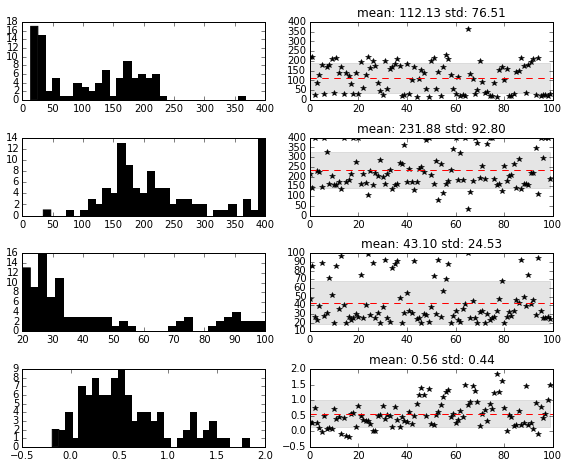

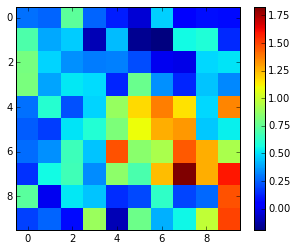

In [173]:
data = parallel_rw_pkl(None, 'patchb2_modis', 'r')
solved = []
for i in data:
    for j in i:
        solved.append([j[0], j[1], j[2][0][0], j[2][0][1], j[2][0][2],j[2][1]])
solved = np.array(solved).T
fig = plt.figure(figsize = (8,8))
for i,j in enumerate(solved[2:]):
    s = i*2
    ax = fig.add_subplot(5,2,s+1)
    ax.hist(j, bins = 30, color='k')
    ax = fig.add_subplot(5,2,s+2)
    ax.plot(j,'k*')
    ax.plot([0,100],[np.mean(j), np.mean(j)], 'r--')
    ax.plot([0,100],[np.mean(j), np.mean(j)], 'r--')
    ax.fill_between(range(100), np.mean(j)-np.std(j), np.mean(j)+np.std(j), alpha=0.2, color='gray')
    ax.set_title('mean: %.2f std: %.2f'%(np.mean(j), np.std(j)))
    print np.mean(j)
plt.tight_layout()
fig = plt.figure(figsize=(5,4))
zeros = np.zeros((10,10))
zeros[(solved[0]).astype(int), (solved[1]).astype(int)] = solved[-1]
plt.imshow(zeros, interpolation ='Nearest')
plt.colorbar()

130.864452573
228.683607558
45.128003799
0.401497211792


<matplotlib.colorbar.Colorbar instance at 0x7f7ab63740e0>

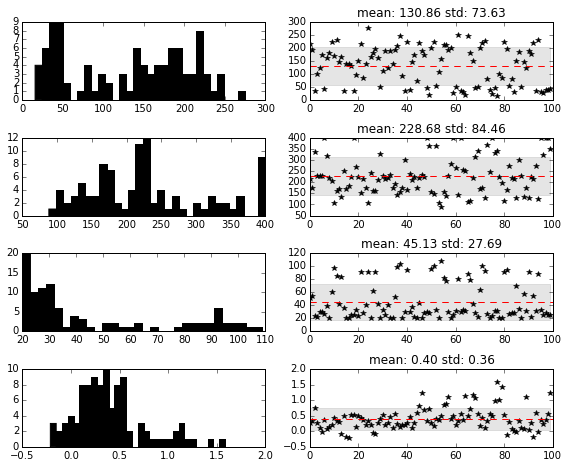

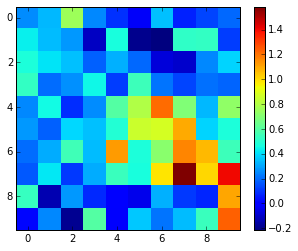

In [172]:
data = parallel_rw_pkl(None, 'patchb3_modis', 'r')
solved = []
for i in data:
    for j in i:
        solved.append([j[0], j[1], j[2][0][0], j[2][0][1], j[2][0][2],j[2][1]])
solved = np.array(solved).T
fig = plt.figure(figsize = (8,8))
for i,j in enumerate(solved[2:]):
    s = i*2
    ax = fig.add_subplot(5,2,s+1)
    ax.hist(j, bins = 30, color='k')
    ax = fig.add_subplot(5,2,s+2)
    ax.plot(j,'k*')
    ax.plot([0,100],[np.mean(j), np.mean(j)], 'r--')
    ax.plot([0,100],[np.mean(j), np.mean(j)], 'r--')
    ax.fill_between(range(100), np.mean(j)-np.std(j), np.mean(j)+np.std(j), alpha=0.2, color='gray')
    ax.set_title('mean: %.2f std: %.2f'%(np.mean(j), np.std(j)))
    print np.mean(j)
plt.tight_layout()
fig = plt.figure(figsize=(5,4))
zeros = np.zeros((10,10))
zeros[(solved[0]).astype(int), (solved[1]).astype(int)] = solved[-1]
plt.imshow(zeros, interpolation ='Nearest')
plt.colorbar()

105.311847159
263.298845162
37.219331883
0.397664190456


<matplotlib.colorbar.Colorbar instance at 0x7f7ab74a89e0>

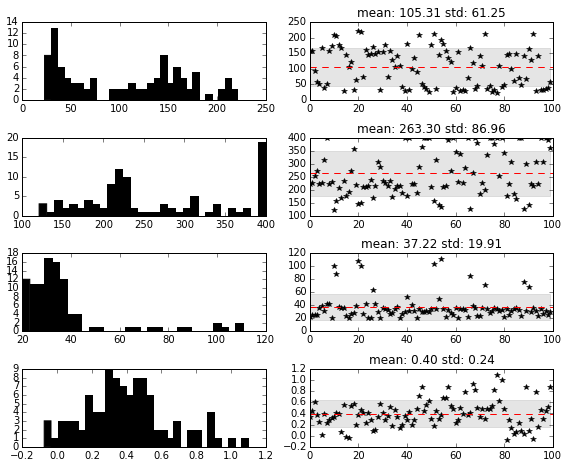

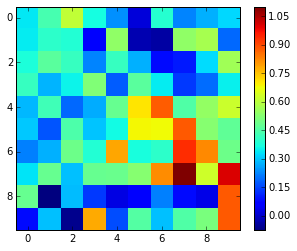

In [171]:
data = parallel_rw_pkl(None, 'patchb4_modis', 'r')
solved = []
for i in data:
    for j in i:
        solved.append([j[0], j[1], j[2][0][0], j[2][0][1], j[2][0][2],j[2][1]])
solved = np.array(solved).T
fig = plt.figure(figsize = (8,8))
for i,j in enumerate(solved[2:]):
    s = i*2
    ax = fig.add_subplot(5,2,s+1)
    ax.hist(j, bins = 30, color='k')
    ax = fig.add_subplot(5,2,s+2)
    ax.plot(j,'k*')
    ax.plot([0,100],[np.mean(j), np.mean(j)], 'r--')
    ax.plot([0,100],[np.mean(j), np.mean(j)], 'r--')
    ax.fill_between(range(100), np.mean(j)-np.std(j), np.mean(j)+np.std(j), alpha=0.2, color='gray')
    ax.set_title('mean: %.2f std: %.2f'%(np.mean(j), np.std(j)))
    print np.mean(j)
plt.tight_layout()
fig = plt.figure(figsize=(5,4))
zeros = np.zeros((10,10))
zeros[(solved[0]).astype(int), (solved[1]).astype(int)] = solved[-1]
plt.imshow(zeros, interpolation ='Nearest')
plt.colorbar()

123.77669589
246.116656273
41.6604186921
0.47986049718


<matplotlib.colorbar.Colorbar instance at 0x7f7abc3f11b8>

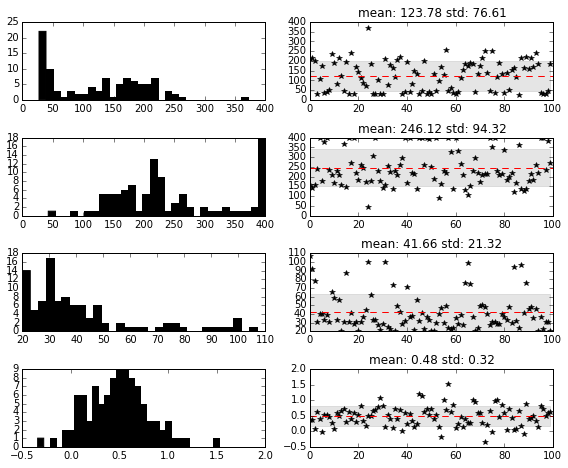

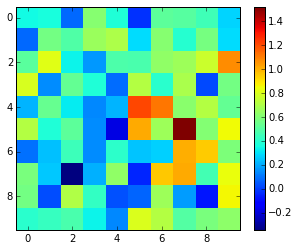

In [170]:
data = parallel_rw_pkl(None, 'patchb8_modis', 'r')
solved = []
for i in data:
    for j in i:
        solved.append([j[0], j[1], j[2][0][0], j[2][0][1], j[2][0][2],j[2][1]])
solved = np.array(solved).T
fig = plt.figure(figsize = (8,8))
for i,j in enumerate(solved[2:]):
    s = i*2
    ax = fig.add_subplot(5,2,s+1)
    ax.hist(j, bins = 30, color='k')
    ax = fig.add_subplot(5,2,s+2)
    ax.plot(j,'k*')
    ax.plot([0,100],[np.mean(j), np.mean(j)], 'r--')
    ax.plot([0,100],[np.mean(j), np.mean(j)], 'r--')
    ax.fill_between(range(100), np.mean(j)-np.std(j), np.mean(j)+np.std(j), alpha=0.2, color='gray')
    ax.set_title('mean: %.2f std: %.2f'%(np.mean(j), np.std(j)))
    print np.mean(j)
plt.tight_layout()
fig = plt.figure(figsize=(5,4))
zeros = np.zeros((10,10))
zeros[(solved[0]).astype(int), (solved[1]).astype(int)] = solved[-1]
plt.imshow(zeros, interpolation ='Nearest')
plt.colorbar()

119.799415472
250.829418703
41.7651818453
0.577313038596


<matplotlib.colorbar.Colorbar instance at 0x7f7abc0a8830>

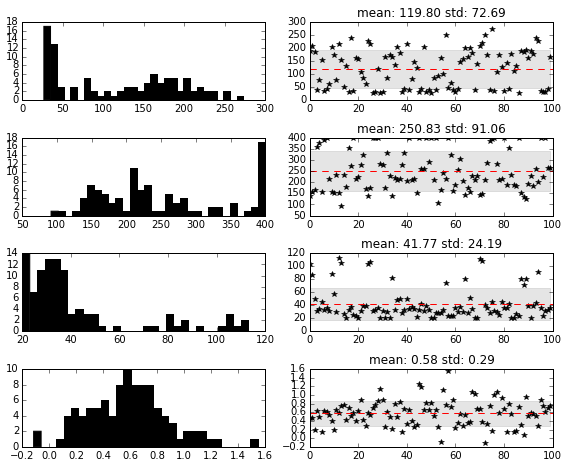

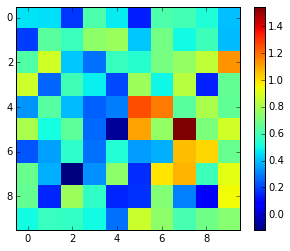

In [169]:
data = parallel_rw_pkl(None, 'patchb8a_modis', 'r')
solved = []
for i in data:
    for j in i:
        solved.append([j[0], j[1], j[2][0][0], j[2][0][1], j[2][0][2],j[2][1]])
solved = np.array(solved).T
fig = plt.figure(figsize = (8,8))
for i,j in enumerate(solved[2:]):
    s = i*2
    ax = fig.add_subplot(5,2,s+1)
    ax.hist(j, bins = 30, color='k')
    ax = fig.add_subplot(5,2,s+2)
    ax.plot(j,'k*')
    ax.plot([0,100],[np.mean(j), np.mean(j)], 'r--')
    ax.plot([0,100],[np.mean(j), np.mean(j)], 'r--')
    ax.fill_between(range(100), np.mean(j)-np.std(j), np.mean(j)+np.std(j), alpha=0.2, color='gray')
    ax.set_title('mean: %.2f std: %.2f'%(np.mean(j), np.std(j)))
    print np.mean(j)
plt.tight_layout()
fig = plt.figure(figsize=(5,4))
zeros = np.zeros((10,10))
zeros[(solved[0]).astype(int), (solved[1]).astype(int)] = solved[-1]
plt.imshow(zeros, interpolation ='Nearest')
plt.colorbar()

153.854372143
226.497242993
44.0178756975
0.900149258128


<matplotlib.colorbar.Colorbar instance at 0x7f7ab7e78638>

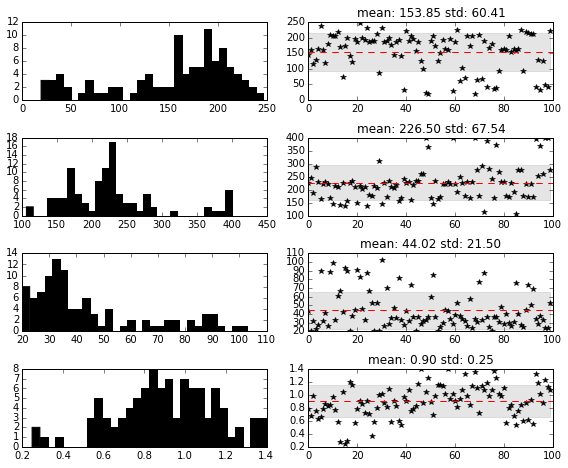

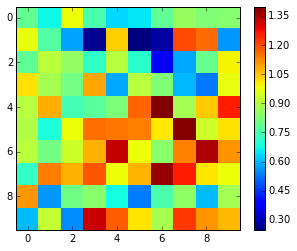

In [168]:
data = parallel_rw_pkl(None, 'patchb11_modis', 'r')
solved = []
for i in data:
    for j in i:
        solved.append([j[0], j[1], j[2][0][0], j[2][0][1], j[2][0][2],j[2][1]])
solved = np.array(solved).T
fig = plt.figure(figsize = (8,8))
for i,j in enumerate(solved[2:]):
    s = i*2
    ax = fig.add_subplot(5,2,s+1)
    ax.hist(j, bins = 30, color='k')
    ax = fig.add_subplot(5,2,s+2)
    ax.plot(j,'k*')
    ax.plot([0,100],[np.mean(j), np.mean(j)], 'r--')
    ax.plot([0,100],[np.mean(j), np.mean(j)], 'r--')
    ax.fill_between(range(100), np.mean(j)-np.std(j), np.mean(j)+np.std(j), alpha=0.2, color='gray')
    ax.set_title('mean: %.2f std: %.2f'%(np.mean(j), np.std(j)))
    print np.mean(j)
plt.tight_layout()
fig = plt.figure(figsize=(5,4))
zeros = np.zeros((10,10))
zeros[(solved[0]).astype(int), (solved[1]).astype(int)] = solved[-1]
plt.imshow(zeros, interpolation ='Nearest')
plt.colorbar()

176.147351097
218.682878383
53.5705612166
0.732592124145


<matplotlib.colorbar.Colorbar instance at 0x7f7ab5af56c8>

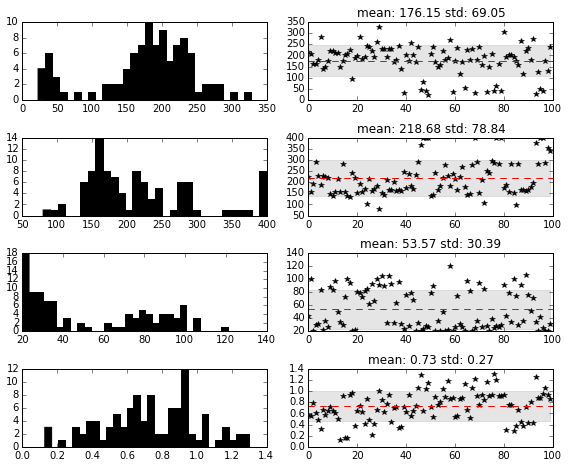

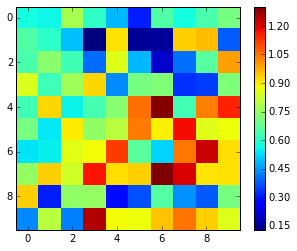

In [174]:
data = parallel_rw_pkl(None, 'patchb12_modis', 'r')
solved = []
for i in data:
    for j in i:
        solved.append([j[0], j[1], j[2][0][0], j[2][0][1], j[2][0][2],j[2][1]])
solved = np.array(solved).T
fig = plt.figure(figsize = (8,8))
for i,j in enumerate(solved[2:]):
    s = i*2
    ax = fig.add_subplot(5,2,s+1)
    ax.hist(j, bins = 30, color='k')
    ax = fig.add_subplot(5,2,s+2)
    ax.plot(j,'k*')
    ax.plot([0,100],[np.mean(j), np.mean(j)], 'r--')
    ax.plot([0,100],[np.mean(j), np.mean(j)], 'r--')
    ax.fill_between(range(100), np.mean(j)-np.std(j), np.mean(j)+np.std(j), alpha=0.2, color='gray')
    ax.set_title('mean: %.2f std: %.2f'%(np.mean(j), np.std(j)))
    print np.mean(j)
plt.tight_layout()
fig = plt.figure(figsize=(5,4))
zeros = np.zeros((10,10))
zeros[(solved[0]).astype(int), (solved[1]).astype(int)] = solved[-1]
plt.imshow(zeros, interpolation ='Nearest')
plt.colorbar()

In [38]:
solves = []
fnames = ['patchb2_modis','patchb3_modis','patchb4_modis',
         'patchb8_modis','patchb8a_modis', 'patchb11_modis','patchb12_modis']
for i in fnames:
    data = parallel_rw_pkl(None, i, 'r')
    solve = []
    for i in data:
        for j in i:
            solve.append([j[0], j[1], j[2][0][0], j[2][0][1], j[2][0][2],j[2][1]])
    solves.append(solve)
solves = np.array(solves)

131.697497459
237.998371502
43.7796070534


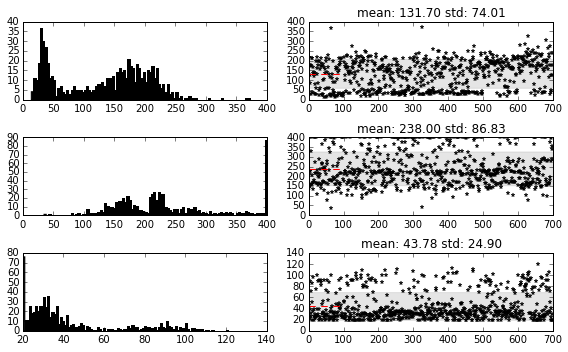

In [260]:
fig = plt.figure(figsize = (8,8))
x = solves.reshape(700, 6).T
for i,j in enumerate(x[2:-1, :]):
    s = i*2
    
    ax = fig.add_subplot(5,2,s+1)
    ax.hist(j, bins = 100, color='k')
    ax = fig.add_subplot(5,2,s+2)
    ax.plot(j,'k*', markersize=4)
    ax.plot([0,100],[np.mean(j), np.mean(j)], 'r--')
    ax.plot([0,100],[np.mean(j), np.mean(j)], 'r--')
    ax.fill_between(range(700), np.mean(j)-np.std(j), np.mean(j)+np.std(j), alpha=0.2, color='gray')
    ax.set_title('mean: %.2f std: %.2f'%(np.mean(j), np.std(j)))
    print np.mean(j)
plt.tight_layout()

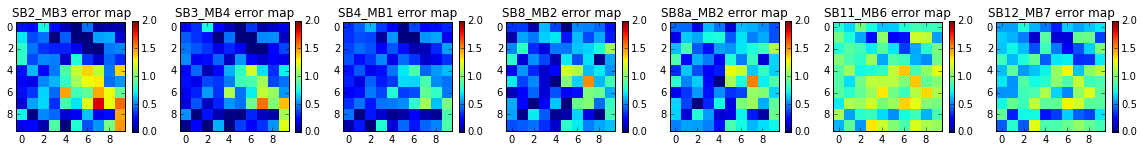

In [278]:
fig = plt.figure(figsize=(20,2))
for i,j in enumerate(solves):
    j = j.T
    ax = fig.add_subplot(1,7,i+1)
    zeros = np.zeros((10,10))
    zeros[(j[0]).astype(int), (j[1]).astype(int)] = j[-1]
    cx = ax.imshow(zeros, interpolation ='Nearest', vmin=0, vmax=2)
    fig.colorbar(cx,ticks=[0.,0.5,1.,1.5,2.])
    ax.set_title('%s error map'%(names[i]))

Obviousely, the errors map show a similar patten, which shows that most of the big errors are from the lower right part, though this is from each band with different parameters. I note that these areas are correspoding to the areas with cloud covered, but much larger coverage than the cloud. Here combining with the previous results for the average without the removal of cloud, I can infer that the cloud has great effects on the relationship between the sentinel TOA  and modis BRDF values, and its influence is larger than its coverage in the real world. Thus, for a linear relstionship between the sentinel TOA reflectance and MODIS BRDF value, we should choose areas that away from the cloud areas. This effects is most obvious on the sentinel band2, which is almost identically correspoinding to the cloud mask on previous results.

####  Use areas that not affected by the cloud or less affected by the cloud to do the experiments.

lest mask out the areas with too big errors, set the threshold to be 0.5.

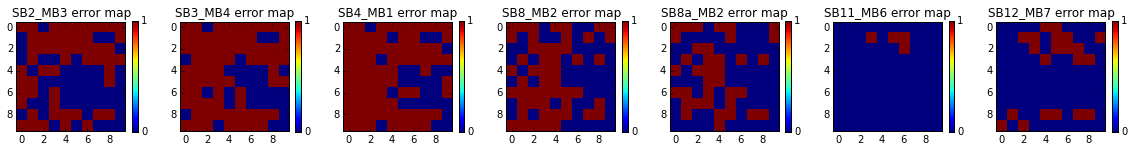

In [310]:
fig = plt.figure(figsize=(20,2))
mask = np.ones((10,10))
for i,j in enumerate(solves):
    j = j.T
    ax = fig.add_subplot(1,7,i+1)
    zeros = np.zeros((10,10))
    zeros[(j[0]).astype(int), (j[1]).astype(int)] = j[-1]
    zeros = zeros<=0.5
    cx = ax.imshow(zeros, interpolation ='Nearest')
    fig.colorbar(cx,ticks=[0,1])
    ax.set_title('%s error map'%(names[i]))
    mask = mask*zeros

(array([1]), array([5]))


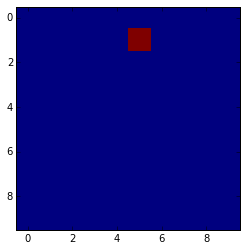

In [313]:
plt.imshow(mask, interpolation = 'Nearest')
print np.where(mask)

Therefore, patch (1,5) can be used to do the experiments showing the correlation between different bands.

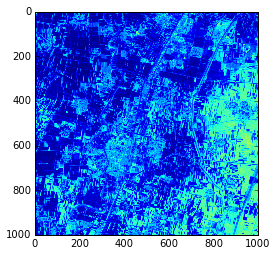

In [316]:
plt.imshow(Sent[1000:2000, 5000:6000])

In [52]:
import multiprocessing
import sys
sys.path.insert(0,'python')
from fastRWpkl import *
import numpy.ma as ma
from readSent import *
from collections import Counter
import cPickle as pkl
from scipy import optimize
from functools import partial
import scipy.ndimage as ndimage
import numpy as np
import scipy
from scipy import signal
import scipy.stats

fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process):    
    xstd,ystd,angle, sx,sy = p
    xwin,ywin = 100,100
    
    i, j = process
    print 'patch %s%s'%(i,j)
    
    s1 = slice((i*1000),(i+1)*1000)
    s2 = slice((j*1000),(j+1)*1000)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    sen_cut = Sent[s1,s2]
    
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    to_regression =[]
    for ii,cx in enumerate(patchx):
        cy = patchy[ii]
        minx = cx+sx - 50
        maxx = cx+sx + 50
        miny = cy+sy - 50
        maxy = cy+sy + 50

        to_conv = Sent[max(0+i*1000, minx): min(1000+i*1000, maxx), max(0+j*1000, miny): min(1000+j*1000, maxy)]
        brdf = modis_sent[cx,cy]*0.001

        if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
            To_conv = to_conv
            Brdf = brdf
            nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
            To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)

            
            gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
            ker = gaus/(gaus.sum())

            s = signal.fftconvolve(To_conv, ker, mode='valid')
            to_regression.append([s[0][0], Brdf])
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)+abs(1-r.slope)**2
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'

    return costs
                
def solve(process):
    solved = []
    for i,j in process:
        p = np.array([22.,40.,43., -3,7])
        bound = np.array([(4., 400.),(4.,400.),(20.,160.), (-10,10), (-10,10)])
        psolve = optimize.fmin_l_bfgs_b(cost,p,approx_grad=True,iprint=-1,args=(([i,j],)),bounds=bound)
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved

<ipython-input-52-58cfa599113b>:77: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression


In [47]:
a = solve(([1,5],))

patch 15
costs: 0.121643414624 rvalue:  0.889139877127 slop:  1.10384262974 
parameters:  [ 22.  40.  43.] 

patch 15
costs: 0.121643414625 rvalue:  0.88913987713 slop:  1.10384262975 
parameters:  [ 22.00000001  40.          43.        ] 

patch 15
costs: 0.121643414623 rvalue:  0.889139877129 slop:  1.10384262975 
parameters:  [ 22.          40.00000001  43.        ] 

patch 15
costs: 0.121643414625 rvalue:  0.889139877126 slop:  1.10384262974 
parameters:  [ 22.          40.          43.00000001] 

patch 15
costs: 0.121643402326 rvalue:  0.889139891492 slop:  1.10384263969 
parameters:  [ 21.99997162  40.00009056  42.99994264] 

patch 15
costs: 0.121643402327 rvalue:  0.889139891494 slop:  1.10384263971 
parameters:  [ 21.99997163  40.00009056  42.99994264] 

patch 15
costs: 0.121643402325 rvalue:  0.889139891494 slop:  1.1038426397 
parameters:  [ 21.99997162  40.00009057  42.99994264] 

patch 15
costs: 0.121643402327 rvalue:  0.889139891491 slop:  1.10384263969 
parameters:  [ 21.

In [55]:
def brute_solve(process):
    solved = []
    for i,j in process:
        rranges = (slice(14., 22., 0.1), slice(86, 117, 0.1), slice(27, 29, 0.1), slice(-10,10,1), slice(-10,10,1))
        resbrute = optimize.brute(cost, rranges, args=([i,j],), full_output=True,finish=optimize.fmin)
        solved.append([i,j,psolve])
        print 'solved one: ', psolve, '\n'
    return solved    

In [ ]:
a = brute_solve(([1,5],))

In [48]:
to_regression = np.array(to_regression).T

LinregressResult(slope=1.0948085071356801, intercept=-0.040632105254042913, rvalue=0.89245132205488753, pvalue=8.2326655257254484e-135, stderr=0.0282424852571109)


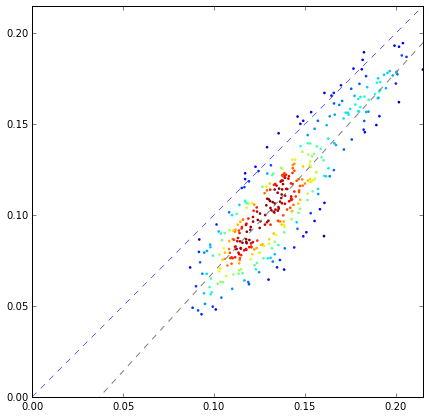

In [49]:
nanm = np.isnan(to_regression[0]) | np.isnan(to_regression[1])
y,x = to_regression[0][~nanm], to_regression[1][~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

###  Applied the solved results mean values to the PSF and compare the results

Here I use band4 as a example firstly.

In [116]:
re_b4 = parallel_rw_pkl(None, 'beb4_modis', 'r')

LinregressResult(slope=1.0141816498268355, intercept=-0.040048110663975817, rvalue=0.86569921172775599, pvalue=0.0, stderr=0.0030349037847299436)


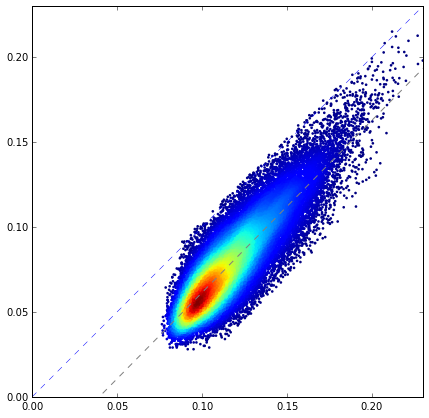

In [119]:
nanm = np.isnan(solves[0]) | np.isnan(solves[1])
y,x = solves[0][~nanm], solves[1][~nanm]
dif = x-y
sigma = np.nanstd(dif)
mean = np.nanmean(dif)

Thr_sigma = 3.*sigma
inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)

x = x[inliers]
y = y[inliers]
maxval = np.nanmax(np.nanmax(y),np.nanmax(x))
xy = np.vstack([y,x])
z = gaussian_kde(xy)(xy)

fit = np.polyfit(y,x,1)
fit_fn = np.poly1d(fit)

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(y, x, c=z, s=7, edgecolor='')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
r = scipy.stats.linregress(y,x)
print r

In [ ]:
fig = plt.figure
gs = gridspec.GridSpec(2,4)  # generate a grid space
fig = plt.figure(figsize=(16,8))

for i in range(7):
    ax = fig.add_subplot(gs[i])
    
    data = np.array(bands[i])
    maxval = np.nanmax(data)
    m = data[:,0][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    s = data[:,1][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    
    dif = m-s
    sigma = np.nanstd(dif)
    mean = np.nanmean(dif)
    
    Thr_sigma = 3.*sigma
    inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)
    
    m = m[inliers]
    s = s[inliers]

    r = scipy.stats.linregress(m,s) # all of the data composed of mean value and brdf
    fit = np.polyfit(m,s,1)
    fit_fn = np.poly1d(fit)
    #plt.figure(figsize = (7,7))
    xy = np.vstack([m,s])
    z = gaussian_kde(xy)(xy)
    ax.scatter(m,s, c=z, s=4, edgecolor='')
    ax.plot([0,1],[0.,1], '--',linewidth=0.5)
    ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
    ax.set_xlim(0, maxval)
    ax.set_ylim(0, maxval)
    ax.set_title('%s'%names[i]+' slop=%.2f'%r.slope+' r=%.2f'%r.rvalue+' inter=%.2f'%r.intercept)
plt.tight_layout()

In [39]:
b4_modis = parallel_rw_pkl(None, 'beb4_modis', 'r')
b2_modis = parallel_rw_pkl(None, 'beb2_modis', 'r')
b3_modis = parallel_rw_pkl(None, 'beb3_modis', 'r')
b8_modis = parallel_rw_pkl(None, 'beb8_modis', 'r')
b8a_modis = parallel_rw_pkl(None, 'beb8a_modis', 'r')
b11_modis = parallel_rw_pkl(None, 'beb11_modis', 'r')
b12_modis = parallel_rw_pkl(None, 'beb12_modis', 'r')

In [40]:
bands = []
for j in [b2_modis,b3_modis,b4_modis,b8_modis,b8a_modis,b11_modis,b12_modis]:
    
    data = []
    for i in j:
        data+=i
    bands.append(data)
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8a_MB2,SB11_MB6,SB12_MB7').split(',')

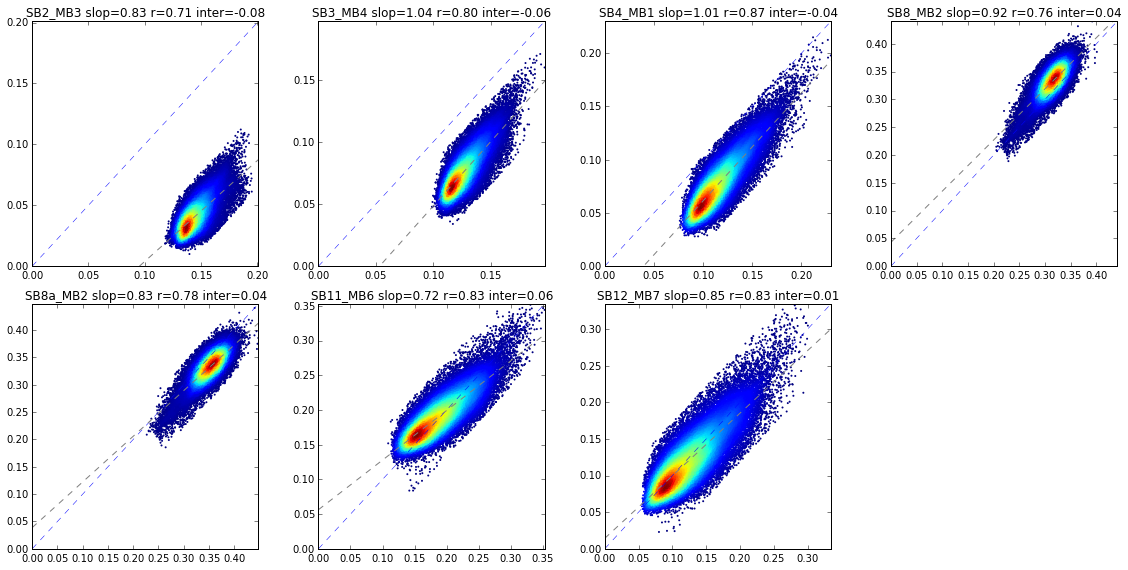

In [124]:
fig = plt.figure
gs = gridspec.GridSpec(2,4)  # generate a grid space
fig = plt.figure(figsize=(16,8))

for i in range(7):
    ax = fig.add_subplot(gs[i])
    
    data = np.array(bands[i])
    maxval = np.nanmax(data)
    m = data[:,0][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    s = data[:,1][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    
    dif = m-s
    sigma = np.nanstd(dif)
    mean = np.nanmean(dif)
    
    Thr_sigma = 3.*sigma
    inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)
    
    m = m[inliers]
    s = s[inliers]

    r = scipy.stats.linregress(m,s) # all of the data composed of mean value and brdf
    fit = np.polyfit(m,s,1)
    fit_fn = np.poly1d(fit)
    #plt.figure(figsize = (7,7))
    xy = np.vstack([m,s])
    z = gaussian_kde(xy)(xy)
    ax.scatter(m,s, c=z, s=4, edgecolor='')
    ax.plot([0,1],[0.,1], '--',linewidth=0.5)
    ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
    ax.set_xlim(0, maxval)
    ax.set_ylim(0, maxval)
    ax.set_title('%s'%names[i]+' slop=%.2f'%r.slope+' r=%.2f'%r.rvalue+' inter=%.2f'%r.intercept)
plt.tight_layout()